<a id='top'></a><a name='top'></a>
# Chapter 8: Unsupervised Methods: Topic Modeling and Clustering

Book: [Blueprints for Text Analysis Using Python](https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/)

Repo: https://github.com/blueprints-for-text-analytics-python/blueprints-text

* [Introduction](#introduction)
* [8.0 Imports and Setup](#8.0)
* [8.1 Our Dataset: UN General Debates](#8.1)
    - [8.1.1 Checking Statistics of the Corpus](#8.1.1)
    - [8.1.2 Preparations](#8.1.2)
* [8.2 Nonnegative Matrix Factorization (NMF)](#8.2)
    - [8.2.1 Blueprint: Creating a Topic Model Using NMF for Documents](#8.2.1)
    - [8.2.2 Blueprint: Creating a Topic Model for Paragraphs Using NMF](#8.2.2)
* [8.3 Latent Semantic Analysis/Indexing](#8.3)
    - [8.3.1 Blueprint: Creating a Topic Model for Paragraphs with SVD](#8.3.1)
* [8.4 Latent Dirichlet Allocation](#8.4)
    - [8.4.1 Blueprint: Creating a Topic Model for Paragraphs with LDA](#8.4.1)
    - [8.4.2 Blueprint: Visualizing LDA Results](#8.4.2)
* [8.5 Blueprint: Using Word Clouds to Display and Compare Topic Models](#8.5)
* [8.6 Blueprint: Calculating Topic Distribution of Documents and Time Evolution](#8.6)
* [8.7 Using Gensim for Topic Modeling](#8.7)
    - [8.7.1 Blueprint: Preparing Data for Gensim](#8.7.1)
    - [8.7.2 Blueprint: Performing Nonnegative Matrix Factorization with Gensim](#8.7.2)
    - [8.7.3 Blueprint: Using LDA with Gensim](#8.7.3)
    - [8.7.4 Blueprint: Calculating Coherence Scores](#8.7.4)
    - [8.7.5 Blueprint: Finding the Optimal Number of Topics](#8.7.5)
    - [8.7.6 Blueprint: Creating a Hierarchical Dirichlet Process with Gensim](#8.7.6)
* [8.8 Blueprint: Using Clustering to Uncover the Structure of Text Data](#8.8)
* [8.9 Further Ideas](#8.9)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* UN General Debates: [script](#un-general-debates-blueprint.csv.gz), [source](https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/un-general-debates/un-general-debates-blueprint.csv.gz)

### Explore

* Explaining the results of supervised ML models.
* Analyzing which features are responsible for model outputs.
* Calculating feature-results using SVM.
* LIME (local interpretable model-agnostic explanations) model.
* Anchor model.

---
<a name='8.0'></a><a id='8.0'></a>
# 8.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
# Start with clean project
# !rm -f *.gz
# !rm -f *.py
# !rm -f *.txt

In [2]:
req_file = "requirements_08.txt"

In [5]:
%%writefile {req_file}
gensim
isort
scikit-learn
pyLDAvis==3.2.2
tqdm
watermark

Overwriting requirements_08.txt


In [6]:
import sys

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [7]:
# !pip install --upgrade --quiet -r requirements_08.txt
# print("Done")

In [58]:
%%writefile imports.py
import locale
import pprint
import re
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis.sklearn
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import HdpModel, LdaModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.nmf import Nmf
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords  # Naive approach
from tqdm import notebook, tqdm, trange
from tqdm.auto import tqdm
from watermark import watermark
from wordcloud import WordCloud

Overwriting imports.py


In [59]:
!isort imports.py
!cat imports.py

Fixing /Users/gpb/Desktop/NLP-LEARNING/nlp-study/blueprints_for_text_analysis/ch08_Topic_Modeling/imports.py
import locale
import pprint
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis.sklearn
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import HdpModel, LdaModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.nmf import Nmf
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords  # Naive approach
from tqdm import notebook, tqdm, trange
from tqdm.auto import tqdm
from watermark import watermark
from wordcloud import WordCloud


---
For pyLDAvis >=  3.4.0, prepare model visualization with:

```
vis = lda_model.prepare(lda_model, doc_term_matrix, dictionary)
```

In [60]:
import locale
import pprint
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis.sklearn
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import HdpModel, LdaModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.nmf import Nmf
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords  # Naive approach
from tqdm import notebook, tqdm, trange
from tqdm.auto import tqdm
from watermark import watermark
from wordcloud import WordCloud

In [61]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

print(watermark(iversions=True, globals_=globals(),python=True, machine=True))

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

Compiler    : Clang 14.0.0 (clang-1400.0.29.202)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

re        : 2.2.1
seaborn   : 0.13.2
matplotlib: 3.9.2
pandas    : 2.2.2
numpy     : 1.26.0
sys       : 3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]
tqdm      : 4.66.5
pyLDAvis  : 3.2.2



---
<a name='8.1'></a><a id='8.1'></a>
# 8.1 Our Dataset: UN General Debates
<a href="#top">[back to top]</a>

<a name='8.1.1'></a><a id='8.1.1'></a>
## 8.1.1 Checking Statistics of the Corpus
<a href="#top">[back to top]</a>

<a id='un-general-debates-blueprint.csv.gz'></a><a name='un-general-debates-blueprint.csv.gz'></a>
### Dataset: un-general-debates-blueprint.csv.gz
<a href="#top">[back to top]</a>

In [15]:
DEBATES_FILE = 'un-general-debates-blueprint.csv.gz'
!wget -nc -q https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/un-general-debates/un-general-debates-blueprint.csv.gz
!ls -l {DEBATES_FILE}

-rw-r--r--  1 gpb  staff  44841131 11  2 22:57 un-general-debates-blueprint.csv.gz


In [16]:
df = pd.read_csv(DEBATES_FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [17]:
# Compare the text of two selected speeches.
print(repr(df.iloc[0]["text"][0:200]))
HR()
print(repr(df.iloc[-1]["text"][0:200]))

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work '
----------------------------------------
'Allow me at the outset to extend to Mr. Mogens Lykketoft my warm congratulations on his election to the high office of President of the General Assembly at its seventieth session. He assumes this offi'


### Split at stops, exclamation points, question marks, etc, and analyze

In [18]:
df["paragraphs"] = df["text"].map(lambda text: re.split('\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

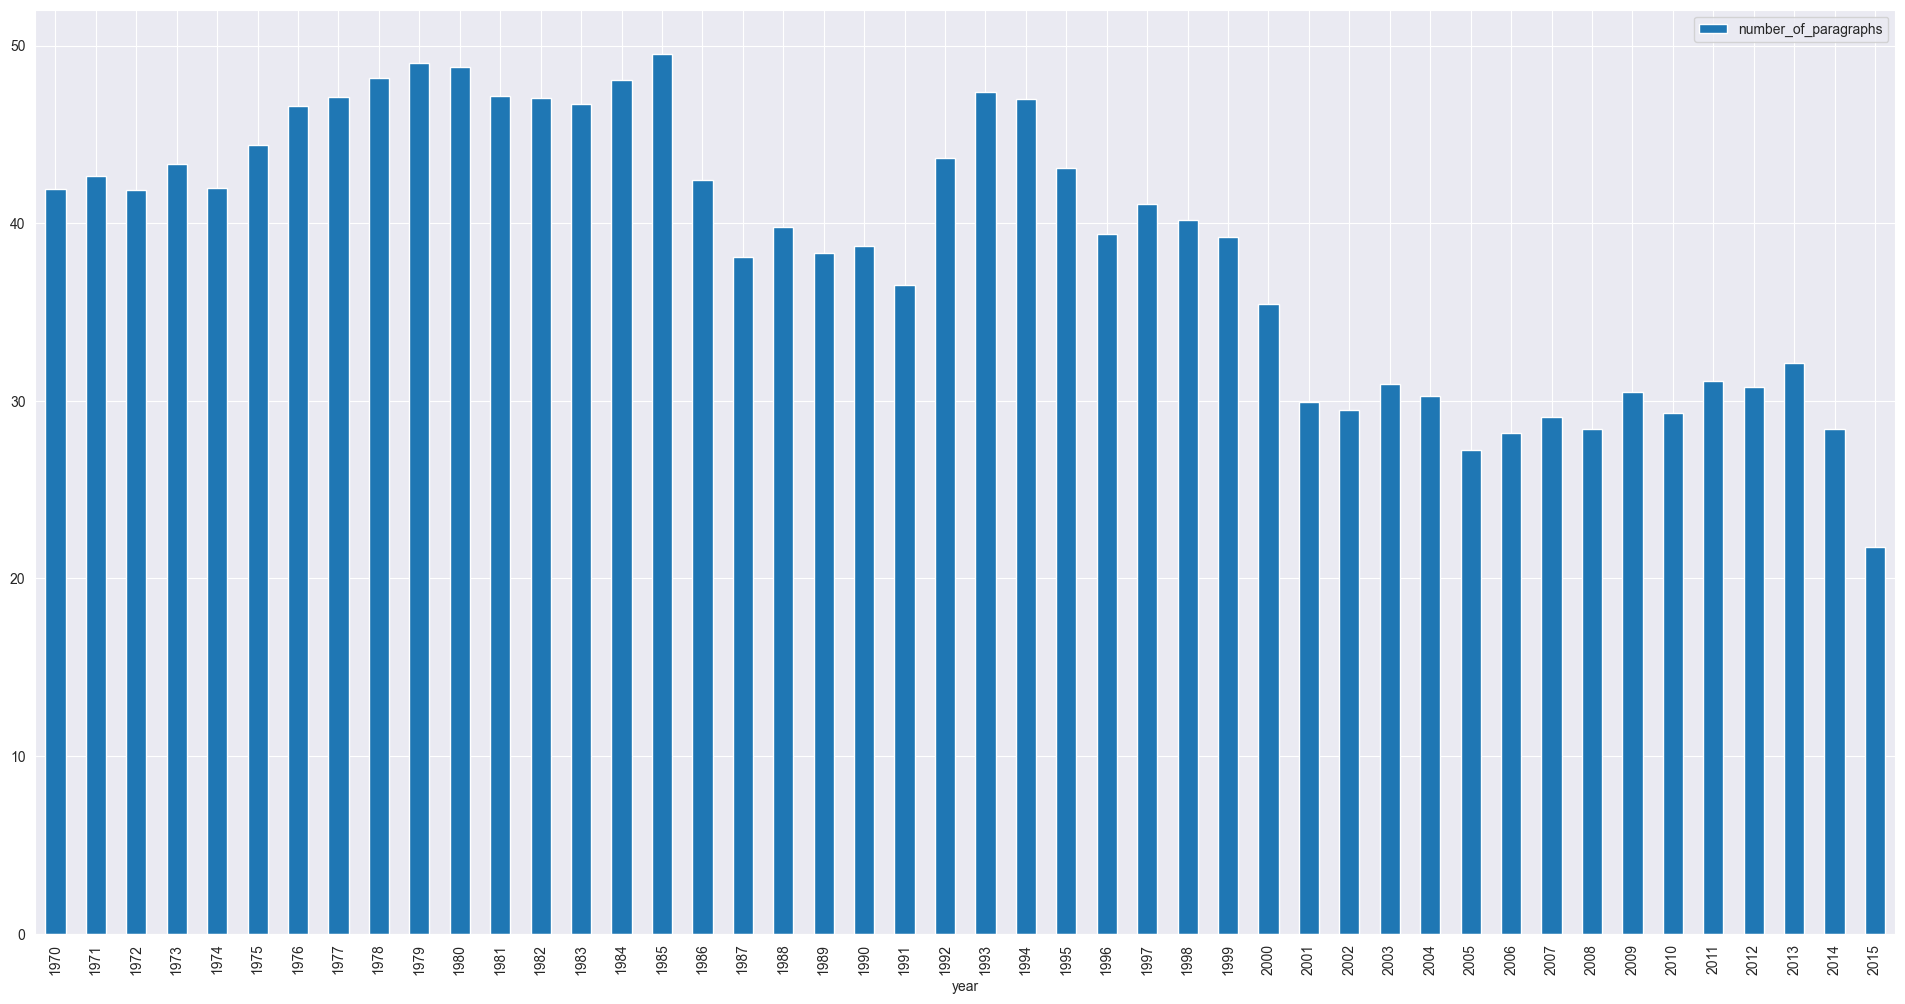

In [19]:
df.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar(figsize=(24,12))
plt.show()

<a name='8.1.2'></a><a id='8.1.2'></a>
## 8.1.2 Preparations
<a href="#top">[back to top]</a>

In [20]:
type(stopwords)
stopwords = list(stopwords)

In [23]:
# Calculate the document-term matrix. Also include bigrams.
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectorizer

TfidfVectorizer(max_df=0.7, min_df=5,
                stop_words=['us', 'still', 'besides', 'for', 'in', 'enough',
                            'never', 'because', 'call', 'one', 'throughout',
                            'this', 'next', 'into', 'used', 'thru', 'where',
                            'made', 'often', 'ours', 'two', 'or', 'whereas',
                            'except', 'first', 'alone', 'everywhere', 'almost',
                            'which', 'on', ...])

In [24]:
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors

<7507x24611 sparse matrix of type '<class 'numpy.float64'>'
	with 5364930 stored elements in Compressed Sparse Row format>

In [25]:
tfidf_text_vectors.shape

(7507, 24611)

In [26]:
# Flatten the paragraphs keeping the years.
# Also omit empty paragraphs.
paragraph_df = pd.DataFrame(
    [
        { "text": paragraph, "year": year } 
        for paragraphs, year in zip(df["paragraphs"], df["year"]) 
            for paragraph in paragraphs if paragraph
    ]
)

paragraph_df

text  year
0       33: May I first convey to our President the co...  1970
1       35.\tThe utilization of the United Nations to ...  1970
2       36.\tThe whole of progressive mankind recalls ...  1970
3       37.\tAll this has had well known consequences ...  1970
4       38.\tOne of the undeniable proofs that the Uni...  1970
...                                                   ...   ...
279071  For some months now, we have watched heartbrea...  2015
279072  This tragic situation could have been avoided ...  2015
279073  My country, Zimbabwe, is committed to a fair, ...  2015
279074  We invite other countries with which we may ha...  2015
279075  The seventieth anniversary of our Organization...  2015

[279076 rows x 2 columns]

In [27]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

(279076, 25162)

---
<a name='8.2'></a><a id='8.2'></a>
# 8.2 Nonnegative Matrix Factorization (NMF)
<a href="#top">[back to top]</a>

<a name='8.2.1'></a><a id='8.2.1'></a>
## 8.2.1 Blueprint: Creating a Topic Model Using NMF for Documents
<a href="#top">[back to top]</a>

In [28]:
# This takes time
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

H_text_matrix

array([[3.30467898e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.06919109e-03],
       [0.00000000e+00, 5.73889067e-02, 2.64588583e-04, ...,
        5.85726968e-03, 6.21973651e-03, 0.00000000e+00],
       [0.00000000e+00, 2.34578067e-02, 4.20985016e-04, ...,
        4.05910588e-03, 0.00000000e+00, 7.74577648e-04],
       ...,
       [0.00000000e+00, 3.14892060e-04, 0.00000000e+00, ...,
        7.27105453e-03, 5.88730940e-04, 0.00000000e+00],
       [3.94574630e-04, 3.31174534e-02, 1.11564965e-05, ...,
        0.00000000e+00, 3.94961485e-03, 0.00000000e+00],
       [1.29333740e-04, 1.07789358e-02, 0.00000000e+00, ...,
        1.14988155e-03, 5.61876603e-03, 0.00000000e+00]])

Analyze this distribution and see whether we can find an interpretation of the topics. 

In [29]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [30]:
# Changed from get_feature_names to get_feature_names_out
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  co (0.79)
  operation (0.65)
  disarmament (0.36)
  nuclear (0.34)
  relations (0.25)

Topic 01
  terrorism (0.38)
  challenges (0.32)
  sustainable (0.30)
  millennium (0.29)
  reform (0.28)

Topic 02
  africa (1.15)
  african (0.82)
  south (0.63)
  namibia (0.36)
  delegation (0.30)

Topic 03
  arab (1.02)
  israel (0.89)
  palestinian (0.60)
  lebanon (0.54)
  israeli (0.54)

Topic 04
  american (0.33)
  america (0.31)
  latin (0.31)
  panama (0.21)
  bolivia (0.21)

Topic 05
  pacific (1.55)
  islands (1.23)
  solomon (0.86)
  island (0.82)
  fiji (0.71)

Topic 06
  soviet (0.81)
  republic (0.78)
  nuclear (0.68)
  viet (0.64)
  socialist (0.63)

Topic 07
  guinea (4.26)
  equatorial (1.75)
  bissau (1.53)
  papua (1.47)
  republic (0.57)

Topic 08
  european (0.61)
  europe (0.44)
  cooperation (0.39)
  bosnia (0.34)
  herzegovina (0.30)

Topic 09
  caribbean (0.98)
  small (0.66)
  bahamas (0.63)
  saint (0.63)
  barbados (0.61)


Normalize the topics.

In [31]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([11.06189432, 17.0213082 , 13.6565622 , 10.18695452, 11.35821532,
        5.95003141,  7.90001101,  4.13937503, 11.91132462,  6.81432338])

<a name='8.2.2'></a><a id='8.2.2'></a>
## 8.2.2 Blueprint: Creating a Topic Model for Paragraphs Using NMF
<a href="#top">[back to top]</a>

### Linear-algebra method

In [32]:
nmf_para_model = NMF(n_components=10, random_state=42)

# Use tfidf_para_vectors to analyze paragraphs
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

H_para_matrix

array([[0.00000000e+00, 2.03796880e-02, 0.00000000e+00, ...,
        6.68754733e-03, 0.00000000e+00, 0.00000000e+00],
       [1.18480535e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.48762926e-04, 0.00000000e+00],
       [6.39910167e-04, 2.63232907e-02, 1.97356458e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.55409594e-04, 1.67166984e-04, 0.00000000e+00],
       [0.00000000e+00, 1.48477361e-02, 6.21677724e-06, ...,
        2.17479383e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.71269400e-02, 1.16649519e-04, ...,
        1.54923114e-03, 5.06662739e-04, 0.00000000e+00]])

In [33]:
# Find the content of the topics.
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
  nations (5.61)
  united (5.50)
  organization (1.27)
  states (1.02)
  charter (0.93)

Topic 01
  general (2.86)
  session (2.83)
  assembly (2.81)
  mr (1.99)
  president (1.81)

Topic 02
  countries (4.41)
  developing (2.49)
  economic (1.50)
  developed (1.35)
  trade (0.92)

Topic 03
  people (1.36)
  peace (1.33)
  east (1.29)
  middle (1.17)
  palestinian (1.16)

Topic 04
  nuclear (4.93)
  weapons (3.26)
  disarmament (2.01)
  treaty (1.71)
  proliferation (1.46)

Topic 05
  rights (6.48)
  human (6.16)
  respect (1.15)
  fundamental (0.85)
  universal (0.82)

Topic 06
  africa (3.80)
  south (3.30)
  african (1.70)
  namibia (1.38)
  apartheid (1.18)

Topic 07
  security (6.10)
  council (5.87)
  permanent (1.49)
  reform (1.49)
  peace (1.29)

Topic 08
  international (2.03)
  world (1.48)
  community (0.91)
  new (0.76)
  peace (0.67)

Topic 09
  development (4.47)
  sustainable (1.19)
  economic (1.06)
  social (0.99)
  goals (0.94)


In [34]:
# What is this?
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([10.42905814, 10.3250673 , 10.19143368,  9.97207971,  6.63847604,
        7.36011502,  8.92422143,  8.31107274, 16.87412537, 10.97435057])

---
<a name='8.3'></a><a id='8.3'></a>
# 8.3 Latent Semantic Analysis/Indexing
<a href="#top">[back to top]</a>

<a name='8.3.1'></a><a id='8.3.1'></a>
## 8.3.1 Blueprint: Creating a Topic Model for Paragraphs with SVD
<a href="#top">[back to top]</a>

In [35]:
svd_para_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

In [36]:
display_topics(svd_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
  nations (0.67)
  united (0.65)
  international (0.58)
  peace (0.46)
  world (0.46)

Topic 01
  general (14.25)
  assembly (13.32)
  session (13.19)
  mr (10.22)
  president (8.76)

Topic 02
  countries (20.95)
  development (16.12)
  economic (15.29)
  developing (14.28)
  session (11.14)

Topic 03
  nations (4.43)
  united (4.07)
  development (0.93)
  organization (0.85)
  charter (0.81)

Topic 04
  nuclear (20.20)
  weapons (13.39)
  disarmament (8.64)
  treaty (6.93)
  proliferation (6.06)

Topic 05
  rights (28.41)
  human (27.71)
  nuclear (8.64)
  weapons (6.05)
  respect (4.81)

Topic 06
  africa (9.02)
  south (8.42)
  united (3.91)
  african (3.89)
  namibia (3.56)

Topic 07
  council (14.36)
  security (13.05)
  africa (7.88)
  south (5.65)
  reform (3.77)

Topic 08
  countries (40.34)
  developing (24.09)
  council (21.92)
  rights (19.05)
  palestinian (17.13)

Topic 09
  development (59.33)
  sustainable (19.32)
  peace (16.94)
  goals (14.87)
  africa (12.88

In [37]:
# Determine the size of the topics by looking at the singular values of the decomposition.
svd_para_model.singular_values_

array([71.58542396, 39.32344616, 36.48183715, 34.81530053, 33.26015445,
       31.44496673, 29.85898267, 28.66414412, 26.99316039, 26.7319264 ])

---
<a name='8.4'></a><a id='8.4'></a>
# 8.4 Latent Dirichlet Allocation
<a href="#top">[back to top]</a>

<a name='8.4.1'></a><a id='8.4.1'></a>
## 8.4.1 Blueprint: Creating a Topic Model for Paragraphs with LDA
<a href="#top">[back to top]</a>

In [39]:
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

(279076, 25162)

### Notes on Latent Dirichlet Allocation (LDA)

https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation

In [42]:
lda_para_model = LatentDirichletAllocation(
    n_components = 10, 
    max_iter=3, # default is 10
    random_state=42,
    verbose=1,
    learning_method='online' # GB see if this is faster
)
lda_para_model

LatentDirichletAllocation(learning_method='online', max_iter=3, random_state=42,
                          verbose=1)

**Note:**

Since this uses probabilistic sampling, this takes a long time to run.

Using COLAB-GPU, this takes 23min.

In [44]:


W_lda_para_matrix = lda_para_model.fit_transform(
    count_para_vectors
)

W_lda_para_matrix

iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3


array([[0.04185786, 0.00068508, 0.00068498, ..., 0.00068507, 0.26615713,
        0.5052951 ],
       [0.00250067, 0.03323734, 0.00250169, ..., 0.00250034, 0.14207533,
        0.65599988],
       [0.2099078 , 0.02569793, 0.00081305, ..., 0.00081318, 0.06862256,
        0.49369419],
       ...,
       [0.00172428, 0.03121784, 0.00172422, ..., 0.06906661, 0.60424785,
        0.00172426],
       [0.12078948, 0.0295996 , 0.02753808, ..., 0.1835906 , 0.18931337,
        0.06782165],
       [0.00263172, 0.13305975, 0.18201342, ..., 0.13970962, 0.07969087,
        0.45236407]])

In [47]:
H_lda_para_matrix = lda_para_model.components_

In [48]:
# View the latent topics of the paragraph corpus.
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())


Topic 00
  peace (3.44)
  region (2.55)
  security (2.12)
  conflict (1.66)
  east (1.56)

Topic 01
  council (1.57)
  conference (1.00)
  resolution (1.00)
  implementation (0.90)
  international (0.87)

Topic 02
  climate (2.12)
  nuclear (1.92)
  weapons (1.70)
  change (1.69)
  environment (1.02)

Topic 03
  development (6.43)
  countries (3.89)
  economic (3.43)
  developing (1.64)
  global (1.60)

Topic 04
  general (6.15)
  assembly (4.91)
  session (3.06)
  president (2.81)
  secretary (2.28)

Topic 05
  country (1.47)
  small (1.22)
  island (1.12)
  forum (1.07)
  lasting (1.07)

Topic 06
  terrorism (2.37)
  people (2.33)
  government (1.63)
  country (1.16)
  right (0.95)

Topic 07
  people (3.10)
  world (1.65)
  country (1.28)
  war (0.98)
  iraq (0.96)

Topic 08
  nations (4.31)
  united (3.95)
  international (2.58)
  security (1.70)
  human (1.47)

Topic 09
  world (2.28)
  africa (2.20)
  years (1.95)
  african (1.81)
  new (1.71)


<a name='8.4.2'></a><a id='8.4.2'></a>
## 8.4.2 Blueprint: Visualizing LDA Results
<a href="#top">[back to top]</a>

In [49]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 9.92561439, 10.22513491,  7.1902454 , 10.7235052 ,  8.71374568,
        4.87222048,  8.46240167,  8.4437515 , 23.61155199,  7.83182878])

In [50]:
# Hack
count_para_vectorizer.get_feature_names = count_para_vectorizer.get_feature_names_out

In [63]:
print("Fitting pyLDAvis.sklearn model")
lda_display = pyLDAvis.sklearn.prepare(
    lda_para_model, 
    count_para_vectors, 
    count_para_vectorizer, 
    sort_topics=False
)

pyLDAvis.display(lda_display)

---
<a name='8.5'></a><a id='8.5'></a>
# 8.5 Blueprint: Using Word Clouds to Display and Compare Topic Models
<a href="#top">[back to top]</a>

In [65]:
def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

We can qualitatively compare the results of the NMF model with those of the LDA model.

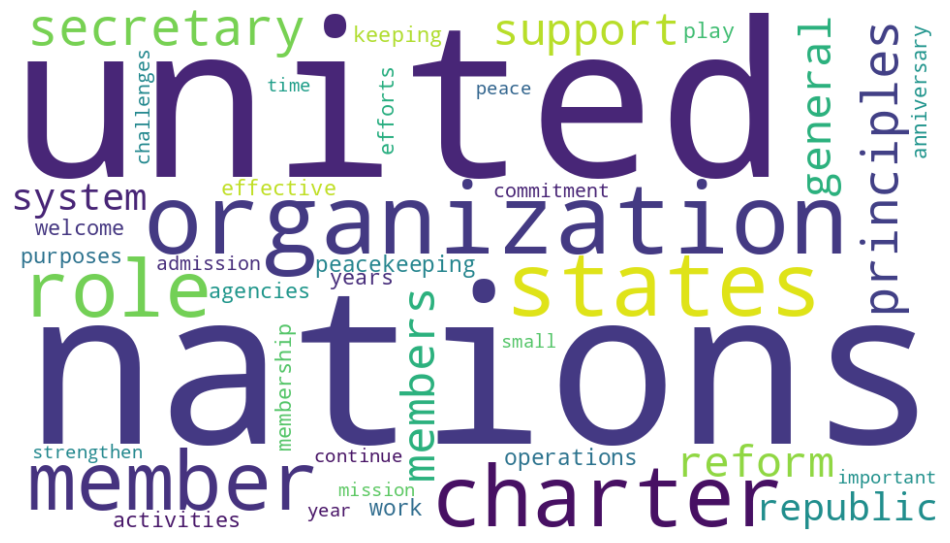

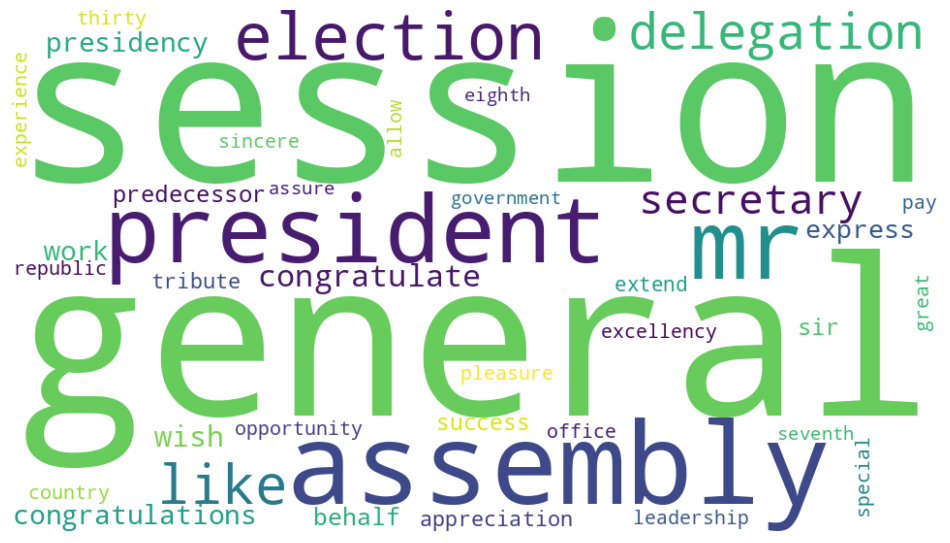

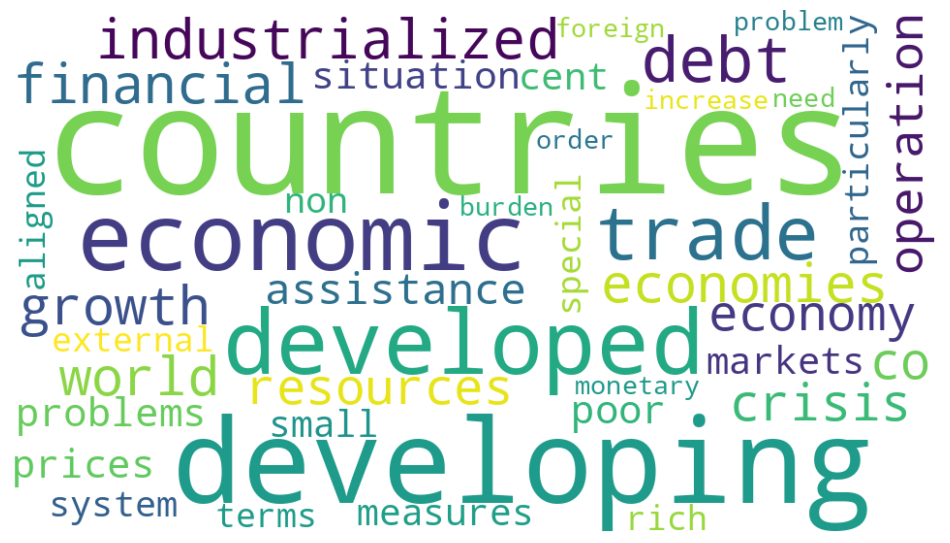

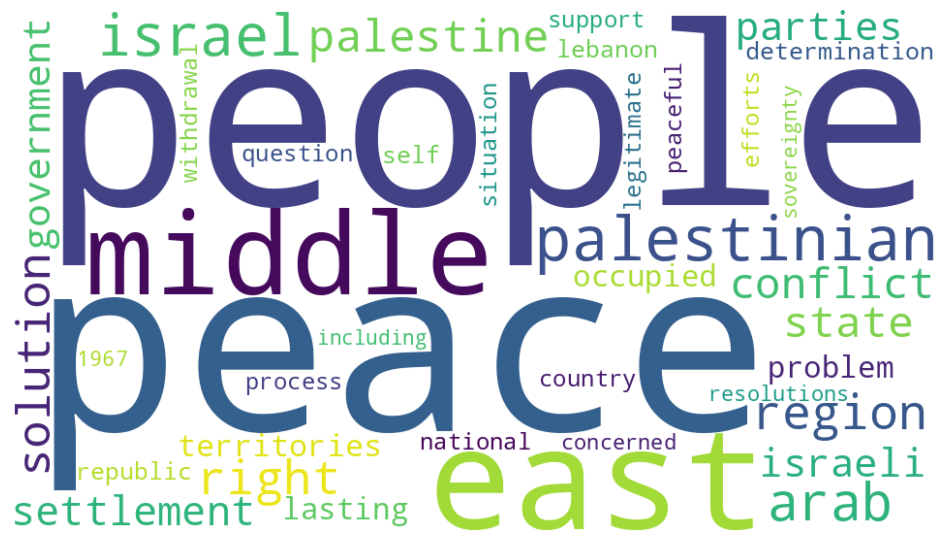

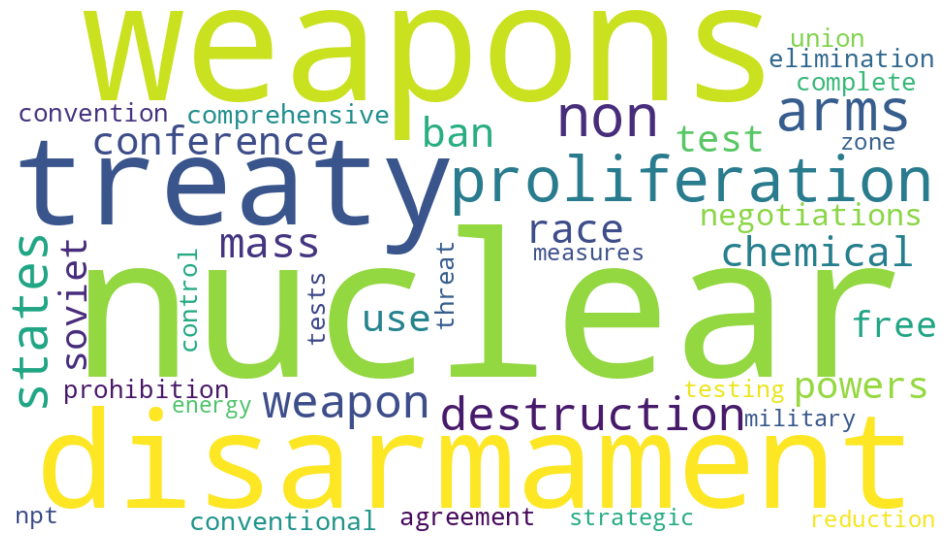

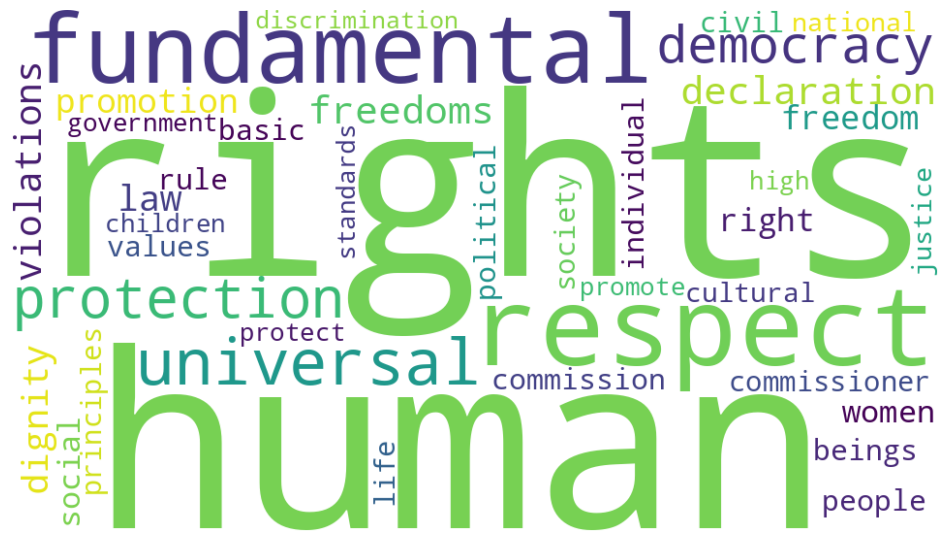

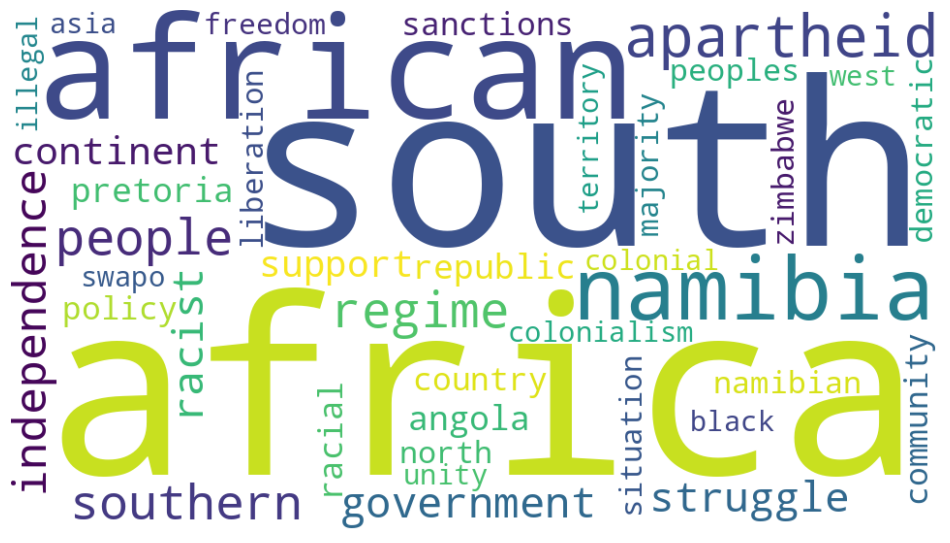

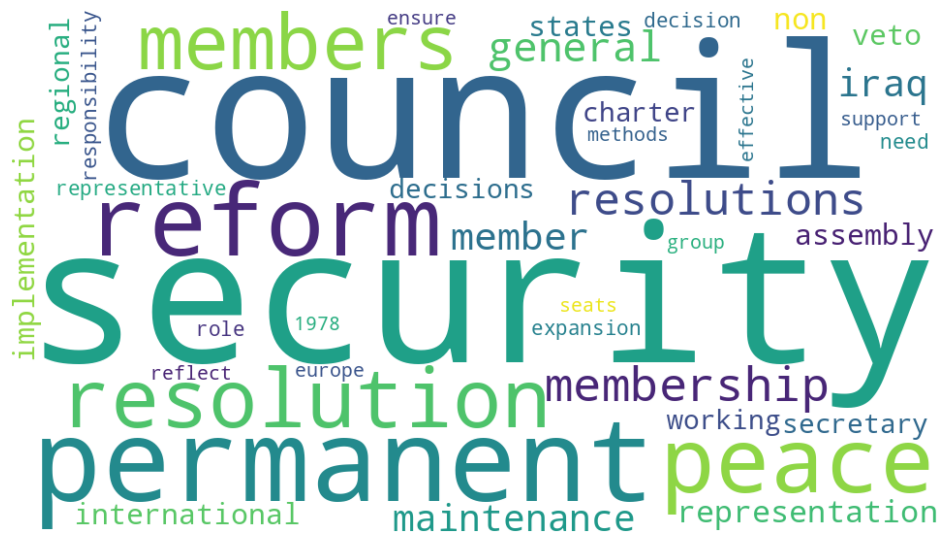

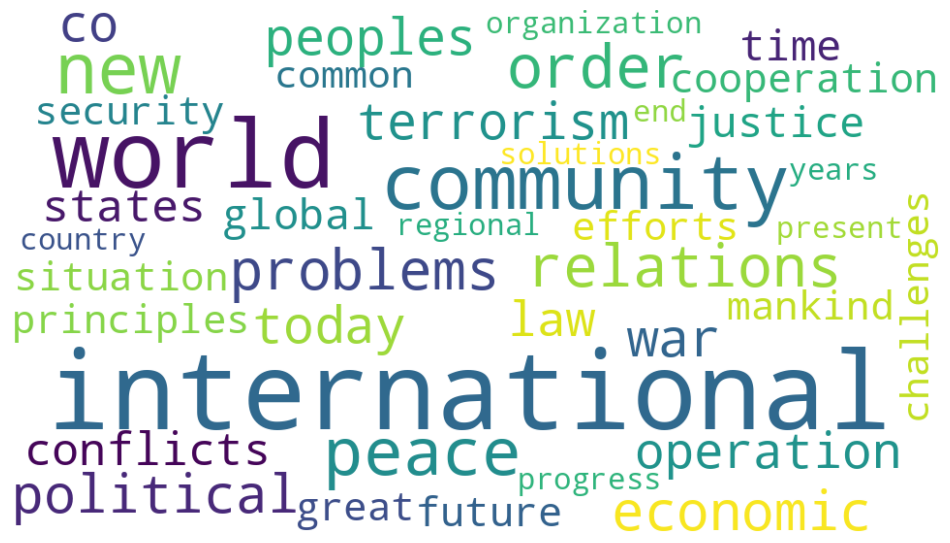

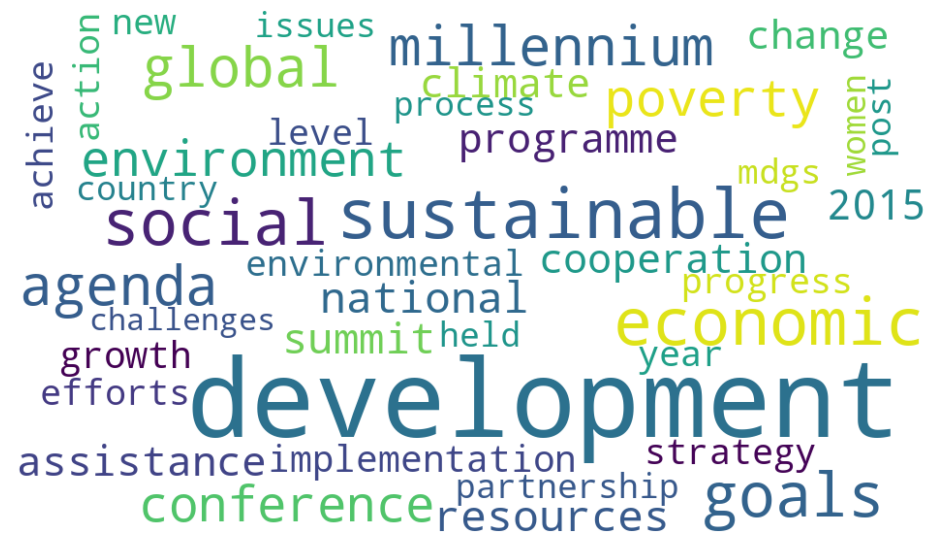

In [66]:
wordcloud_topics(
    nmf_para_model, 
    tfidf_para_vectorizer.get_feature_names_out()
)

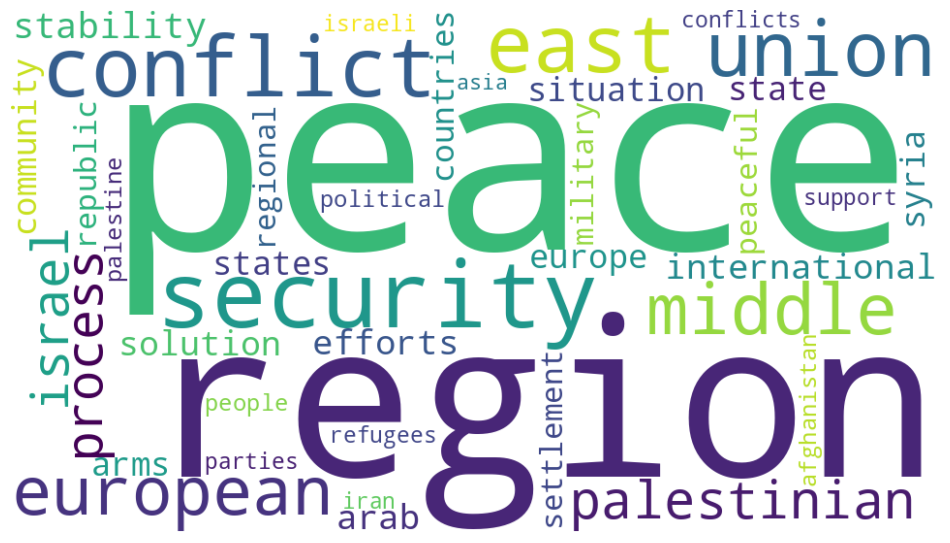

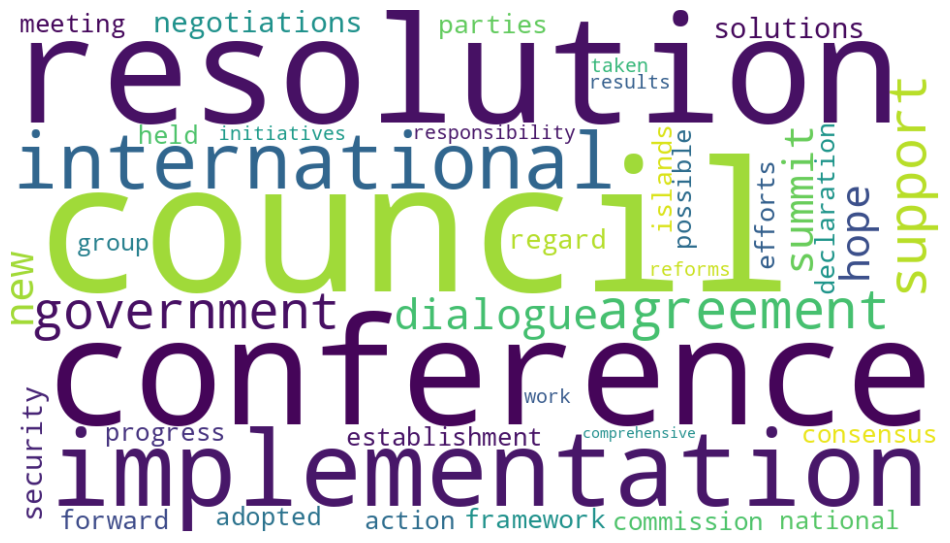

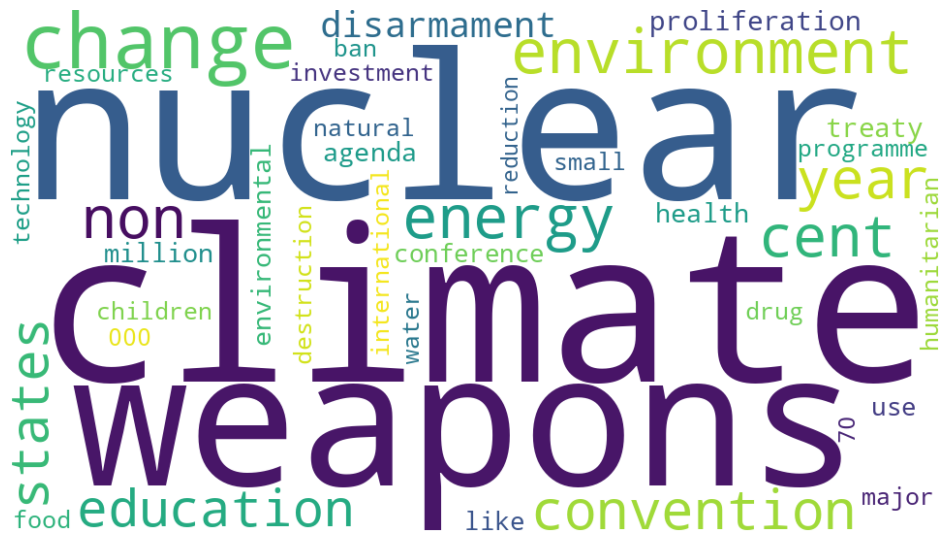

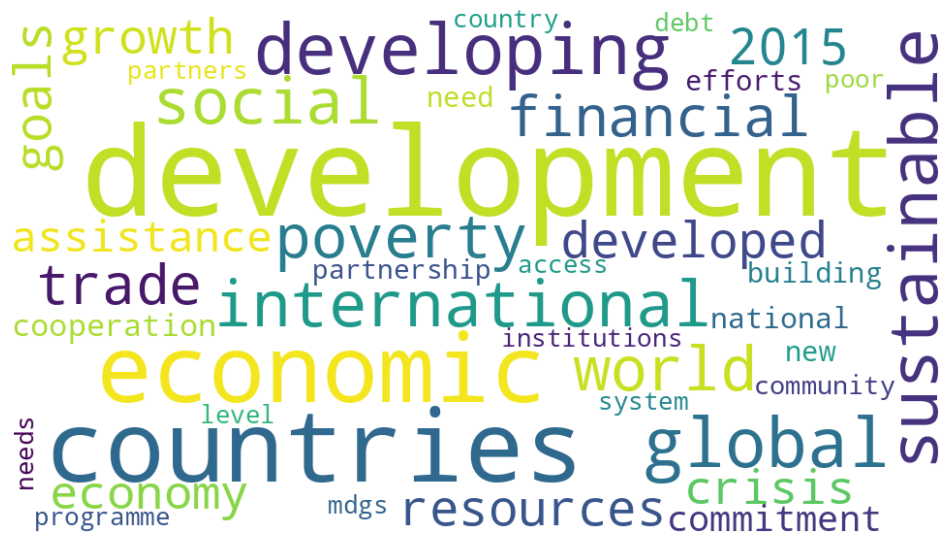

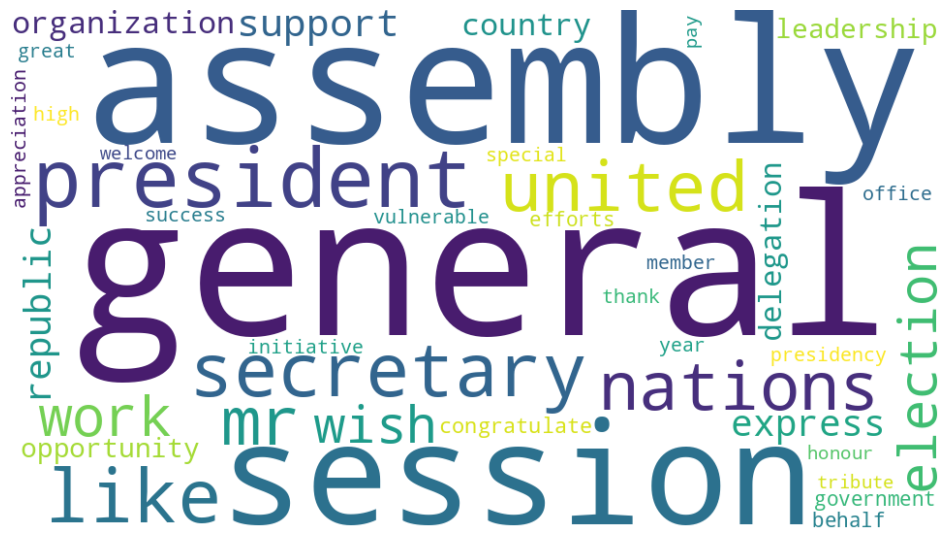

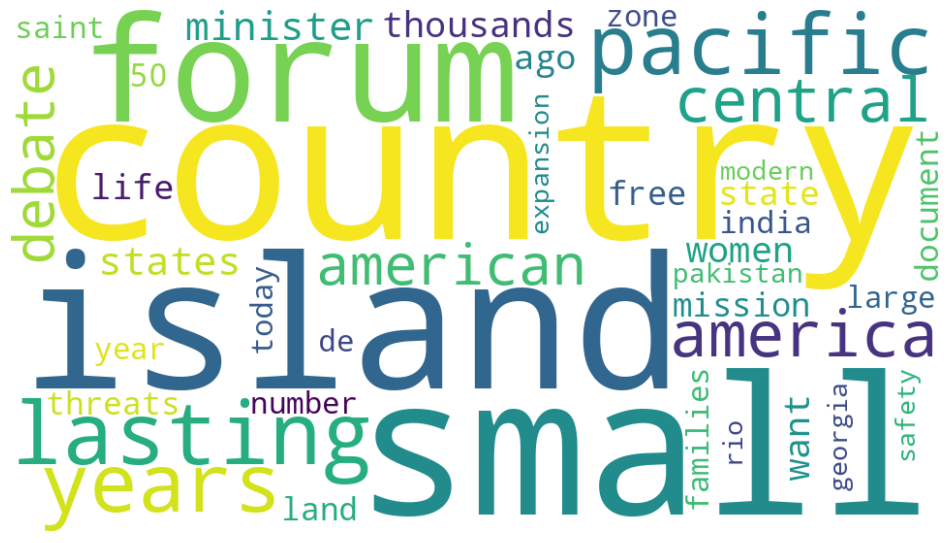

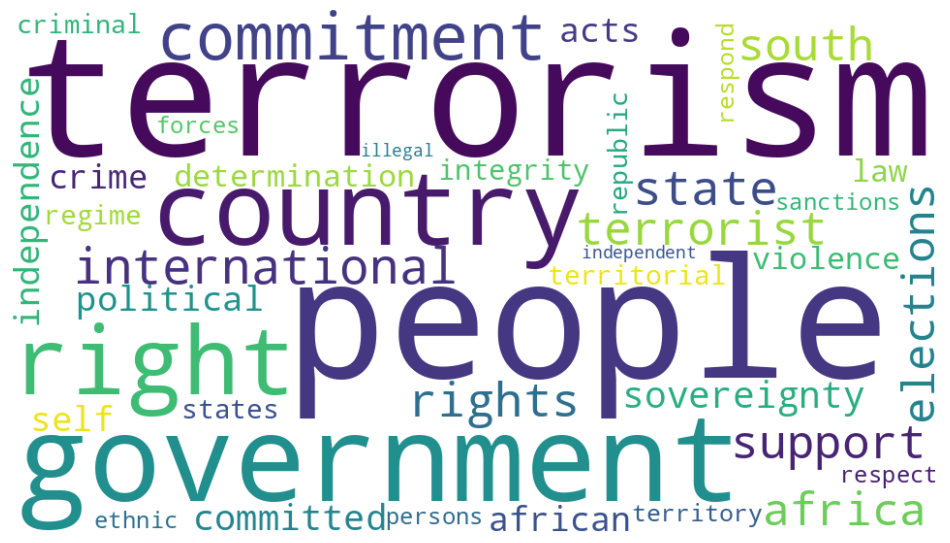

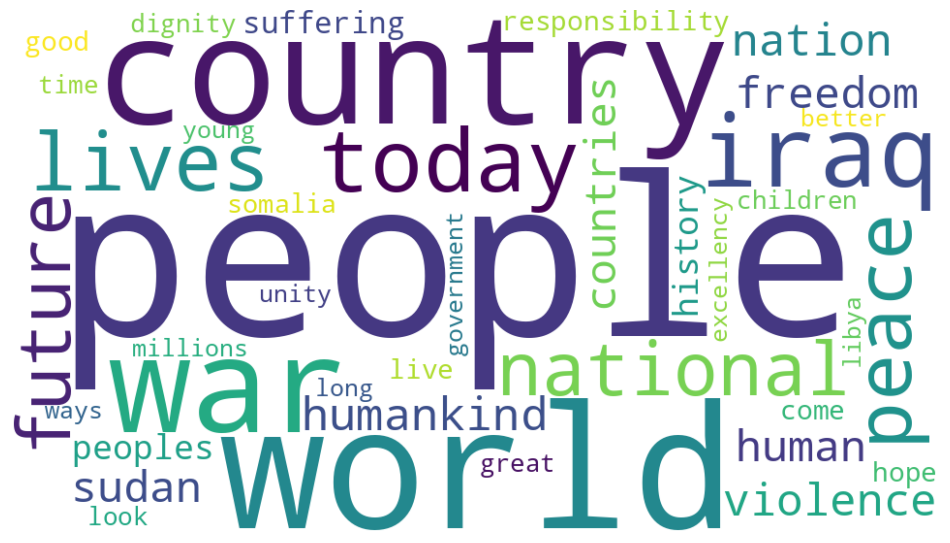

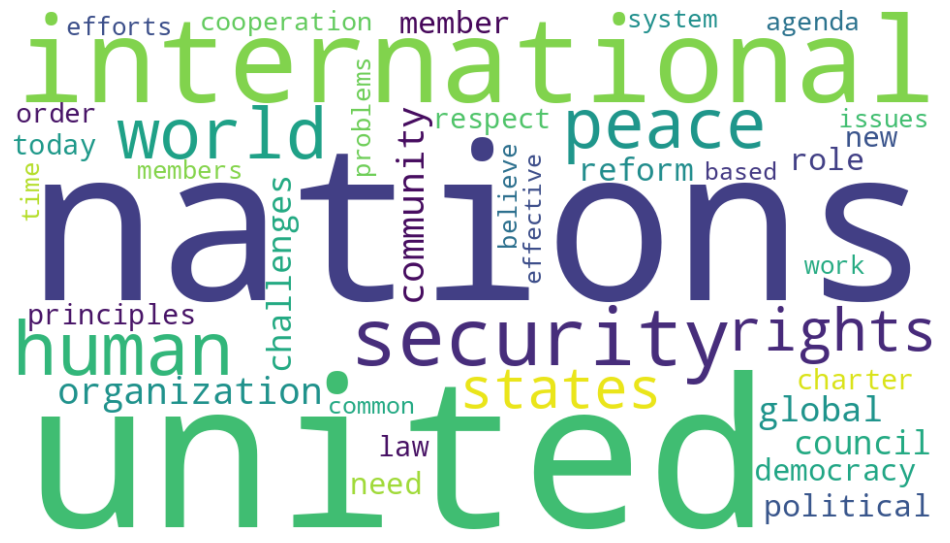

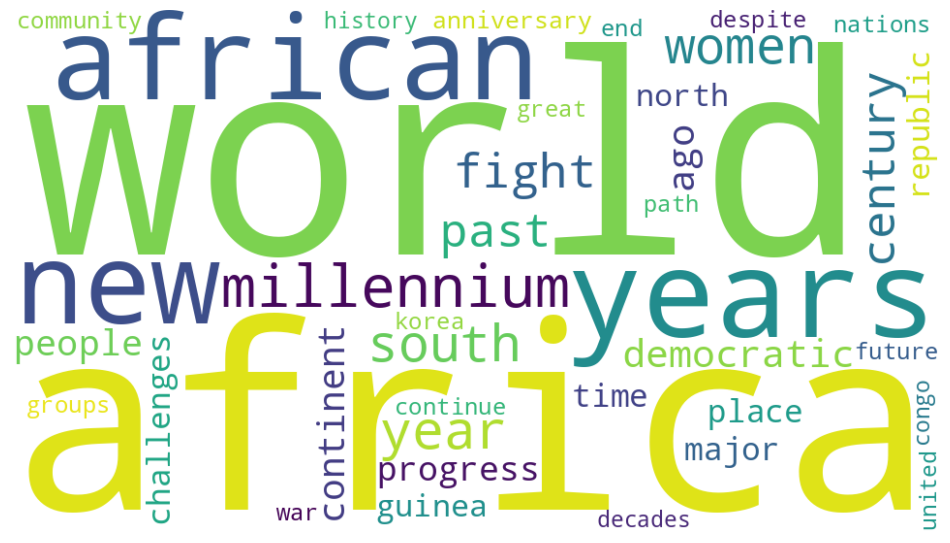

In [67]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

---
<a name='8.6'></a><a id='8.6'></a>
# 8.6 Blueprint: Calculating Topic Distribution of Documents and Time Evolution
<a href="#top">[back to top]</a>

In [68]:
# What is this??
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([10.42905814, 10.3250673 , 10.19143368,  9.97207971,  6.63847604,
        7.36011502,  8.92422143,  8.31107274, 16.87412537, 10.97435057])

In [69]:
# Create NumPy arrays for documents before and after 1990.
before_1990 = np.array(paragraph_df["year"] < 1990)
after_1990 = ~ before_1990

In [70]:
# Calculate the respective W matrices.
W_para_matrix_early = nmf_para_model.transform(tfidf_para_vectors[before_1990])
W_para_matrix_late  = nmf_para_model.transform(tfidf_para_vectors[after_1990])
print(W_para_matrix_early.sum(axis=0)/W_para_matrix_early.sum()*100.0)
print(W_para_matrix_late.sum(axis=0)/W_para_matrix_late.sum()*100.0)

[ 9.20962178 10.45479064 12.23762512 11.96923534  7.83419198  6.07025801
 12.22928118  5.87559699 17.43863725  6.68076171]
[11.40231656 10.22115968  8.55802537  8.38145136  5.68415097  8.38983684
  6.28414804 10.25571869 16.42180086 14.40139163]


In [71]:
['%1.2f'%x for x in W_para_matrix_early.sum(axis=0)/W_para_matrix_early.sum()*100.0]

['9.21',
 '10.45',
 '12.24',
 '11.97',
 '7.83',
 '6.07',
 '12.23',
 '5.88',
 '17.44',
 '6.68']

In [72]:
['%1.2f'%x for x in W_para_matrix_early.sum(axis=0)/W_para_matrix_late.sum()*100.0]

['7.35',
 '8.35',
 '9.77',
 '9.55',
 '6.25',
 '4.85',
 '9.76',
 '4.69',
 '13.92',
 '5.33']

In [73]:
# Calculate the distribution for individual years and see whether we can find
# a visualization to uncover possible patterns.

year_data = []

for year in tqdm(np.unique(np.unique(paragraph_df["year"]))):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

  0%|          | 0/46 [00:00<?, ?it/s]

In [74]:
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names_out()

for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

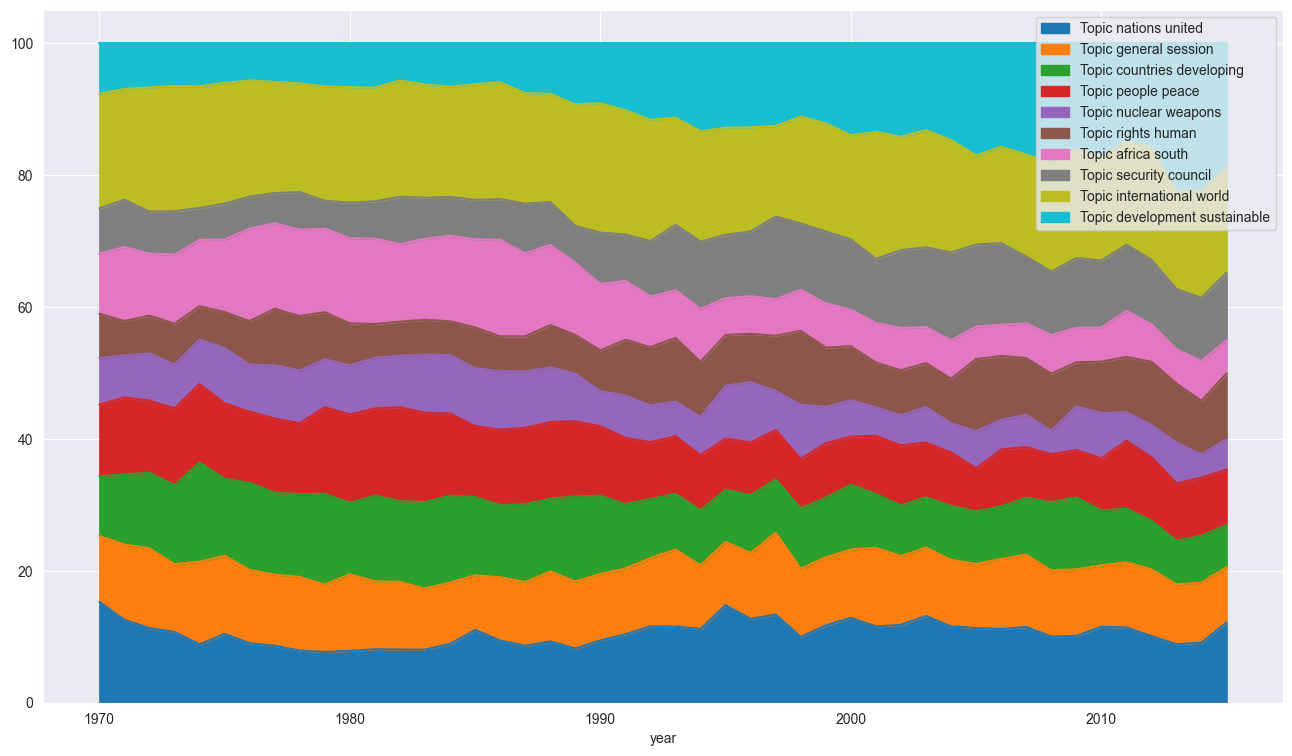

In [75]:
# Combine the results in a DataFrame with the previous topics as column names. 
df_year = pd.DataFrame(year_data, columns=["year"] + topic_names).set_index("year")
df_year.plot.area(figsize=(16,9))
plt.show()

In [76]:
[f'Topic {count_para_vectorizer.get_feature_names()[words.argsort()[-1]]}' for words in nmf_para_model.components_]

['Topic nations',
 'Topic general',
 'Topic countries',
 'Topic people',
 'Topic nuclear',
 'Topic rights',
 'Topic africa',
 'Topic security',
 'Topic international',
 'Topic development']

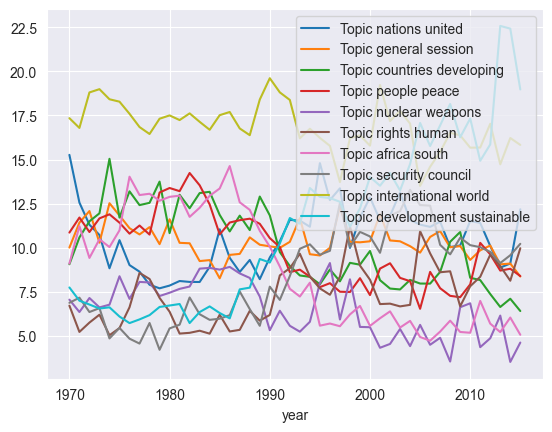

In [77]:
df_year.plot()
plt.show()

# Optimal number of topics

In [ ]:
lda_para_model.perplexity(tfidf_para_vectors)

In [79]:
# This can take over 20 minutes
print("Training lda_model")

lda_para_model_n = []
for n in tqdm(range(5, 6)): # range(5, 21)
    lda_model = LatentDirichletAllocation(
        n_components = n, 
        random_state=42, 
        verbose=1,
        max_iter=3,
        learning_method='online' # GB
    )
    lda_model.fit_transform(count_para_vectors)
    lda_perplexity = lda_model.perplexity(tfidf_para_vectors)
    lda_para_model_n.append((lda_model, lda_perplexity))

Training lda_model


  0%|          | 0/1 [00:00<?, ?it/s]

iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3


In [80]:
lda_para_model_n

[(LatentDirichletAllocation(learning_method='online', max_iter=3, n_components=5,
                            random_state=42, verbose=1),
  9504.510458118872)]

---
<a name='8.7'></a><a id='8.7'></a>
# 8.7 Using Gensim for Topic Modeling
<a href="#top">[back to top]</a>

<a name='8.7.1'></a><a id='8.7.1'></a>
## 8.7.1 Blueprint: Preparing Data for Gensim
<a href="#top">[back to top]</a>

In [84]:
# Create tokenized documents.
gensim_paragraphs = [
    [w for w in re.findall(r'\b\w\w+\b' , paragraph.lower()) if w not in stopwords] 
    for paragraph in paragraph_df["text"]]

print("Done")

Done


In [85]:
dict_gensim_para = Dictionary(gensim_paragraphs) 

In [86]:
dict_gensim_para.filter_extremes(no_below=5, no_above=0.7)

In [87]:
# Calculate the bag-of-words matrix. 
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [88]:
# Perform the TF-IDF transformation.
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

<a name='8.7.2'></a><a id='8.7.2'></a>
## 8.7.2 Blueprint: Performing Nonnegative Matrix Factorization with Gensim
<a href="#top">[back to top]</a>

In [ ]:
nmf_gensim_para = Nmf(
    vectors_gensim_para, 
    num_topics=10, 
    id2word=dict_gensim_para, 
    kappa=0.1, 
    eval_every=5, 
    random_state=42
) 

In [ ]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [ ]:
display_topics_gensim(nmf_gensim_para)

In [ ]:
# Calculate the coherence score for topic models, a quality indicator.
nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para, texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()
print(nmf_gensim_para_coherence_score)

<a name='8.7.3'></a><a id='8.7.3'></a>
## 8.7.3 Blueprint: Using LDA with Gensim
<a href="#top">[back to top]</a>

In [ ]:
# This takes a long time, around 21 minutes using COLAB GPU

lda_gensim_para = LdaModel(
    corpus=bow_gensim_para, 
    id2word=dict_gensim_para, 
    chunksize=2000,
    alpha='auto', 
    eta='auto', 
    iterations=400, 
    num_topics=10, 
    passes=20, 
    eval_every=None, 
    random_state=42
)

In [ ]:
display_topics_gensim(lda_gensim_para)

In [ ]:
lda_gensim_para.log_perplexity(vectors_gensim_para)

<a name='8.7.4'></a><a id='8.7.4'></a>
## 8.7.4 Blueprint: Calculating Coherence Scores
<a href="#top">[back to top]</a>

In [ ]:
%%time
lda_gensim_para_coherence = CoherenceModel(
    model=lda_gensim_para, 
    texts=gensim_paragraphs, 
    dictionary=dict_gensim_para, 
    coherence='c_v'
)

lda_gensim_para_coherence_score = lda_gensim_para_coherence.get_coherence()

print(lda_gensim_para_coherence_score)

In [ ]:
print(lda_gensim_para_coherence_score)

In [ ]:
lda_gensim_para.alpha

In [ ]:
%%time
nmf_gensim_para_coherence = CoherenceModel(
    model=nmf_gensim_para, 
    texts=gensim_paragraphs, 
    dictionary=dict_gensim_para, 
    coherence='c_v'
)

nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()

print(nmf_gensim_para_coherence_score)

In [ ]:
top_topics = lda_gensim_para.top_topics(vectors_gensim_para, topn=5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

In [ ]:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

<a name='8.7.5'></a><a id='8.7.5'></a>
## 8.7.5 Blueprint: Finding the Optimal Number of Topics
<a href="#top">[back to top]</a>

p. 232

We want to find the optimal number
of topics in a structured way without having to go into the interpretation of each constellation.

### The next cell takes too long to run even on COLAB.

In [ ]:
%%time

# This takes a long time, over 2H!

lda_para_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LdaMulticore(
        corpus=bow_gensim_para, 
        id2word=dict_gensim_para, 
        chunksize=2000,
        eta='auto', 
        iterations=400, 
        num_topics=n, 
        passes=20, 
        eval_every=None, 
        random_state=42
    )
    
    lda_coherence = CoherenceModel(
        model=lda_model, 
        texts=gensim_paragraphs, 
        dictionary=dict_gensim_para, 
        coherence='c_v'
    )
    
    lda_para_model_n.append(
        (n, lda_model, lda_coherence.get_coherence())
    )

In [ ]:
pd.DataFrame(lda_para_model_n, columns=["n", "model", "coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))

In [ ]:
display_topics_gensim(lda_para_model_n[12][1])

In [ ]:
def wordcloud_topics_gensim(model, no_top_words=40):
    for topic in range(0, model.num_topics):
        size = {}
        for (word, prob) in model.show_topic(topic, topn=no_top_words):
            size[word] = prob
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

In [ ]:
wordcloud_topics_gensim(lda_para_model_n[12][1])

<a name='8.7.6'></a><a id='8.7.6'></a>
## 8.7.6 Blueprint: Creating a Hierarchical Dirichlet Process with Gensim
<a href="#top">[back to top]</a>

In [ ]:
hdp_gensim_para = HdpModel(corpus=bow_gensim_para, id2word=dict_gensim_para)

In [ ]:
words = 8
pd.DataFrame([re.split(r" \+ |\*", t[1]) for t in hdp_gensim_para.print_topics(num_topics=20, num_words=words)])

In [ ]:
# pd.set_option('max_colwidth', 1000)

pd.DataFrame(
    hdp_gensim_para.print_topics(
        num_topics=40, 
        num_words=10
    ), 
    columns=["topic", "words"]
).set_index("topic")

In [ ]:
hdp_gensim_para.show_topic(0, topn=10)

In [ ]:
def display_topics_gensim_hdp(model, num_topics):
    for topic in range(0, num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=10):
            print("  %s (%2.2f)" % (word, prob))

In [ ]:
display_topics_gensim_hdp(hdp_gensim_para, 50)

<a name='8.8'></a><a id='8.8'></a>
# 8.8 Blueprint: Using Clustering to Uncover the Structure of Text Data
<a href="#top">[back to top]</a>

In [ ]:
k_means_para = KMeans(n_clusters=10, random_state=42)
k_means_para.fit(tfidf_para_vectors)

In [ ]:
sizes = []
for i in range(10):
    sizes.append({"cluster": i, "size": np.sum(k_means_para.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))
plt.show()

In [ ]:
np.unique(k_means_para.labels_, return_counts=True)

In [ ]:
def wordcloud_clusters(model, vectors, features, no_top_words=40):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

In [ ]:
wordcloud_clusters(
    k_means_para, 
    tfidf_para_vectors, 
    tfidf_para_vectorizer.get_feature_names()
)

---
<a name='8.9'></a><a id='8.9'></a>
# 8.9 Further Ideas
<a href="#top">[back to top]</a>

* It’s possible to add n-grams in the vectorization process. In scikit-learn this is straightforward by using the ngram_range parameter. Gensim has a special Phrases class for that. Due to the higher TF-IDF weights of n-grams, they can contribute considerably to the features of a topic and add a lot of context information.
* As we have used years to have time-dependent topic models, you could also use countries or continents and find the topics that are most relevant in the speeches of their ambassadors.
* Calculate the coherence score for an LDA topic model using the whole speeches instead of the paragraphs and compare the scores.